# Exploration of Data 

This notebook covers the processing of the provided JSONL data into Pandas DataFrames. It also includes the calculation of corpus statistics, focusing on data point lengths, the distribution of labels across annotators, and the agreement levels among annotators.

### Installation and import of libraries

In [1]:
!pip install transformers -q
!pip install torch -q
!pip install textblob -q
!pip install spacy -q
!pip install transformers[torch] -q
!pip install accelerate -U -q
!python -m spacy download de_core_news_md -q
!pip install germansentiment -q
!pip install krippendorff -q

✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_md')


In [2]:
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from spacy.lang.de.examples import sentences
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from germansentiment import SentimentModel
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from statistics import mean, median

In [3]:
spacy.load('de_core_news_md')
nltk.download('stopwords')
nltk.download('punkt')

# 'A006' and 'A011' were removed by the organizers of GermEval2024
ANNOTATOR_COLUMNS = ['A001', 'A002', 'A003', 'A004', 'A005', 'A007', 'A008', 'A009', 'A010', 'A012']

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Processing JSONL data into Pandas DataFrame

In [ ]:
class CreateDataFrame():
    """
    A class used to create and process dataframes.
    Data in JSONL format into Pandas DataFrame
    
    Args:
        nlp: The spaCy language model for German text processing.
        replace_dict (dic): Dictionary for replacing certain labels in the dataframe.
        label_mapping (dic): Dictionary for mapping string labels to numeric labels.
    """
    
    def __init__(self):
        self.nlp = spacy.load('de_core_news_md')
        self.replace_dict = {0: -1, 1: 0, 2: 1, 3: 2, 4: 3} 
        self.label_mapping = {'0-Kein': 0, '1-Gering': 1, '2-Vorhanden': 2, '3-Stark': 3, '4-Extrem': 4}

    def read_dataframe(self, path):
        """
        Reads data from a JSONL file and returns it as a list of dictionaries.
        """
        data = []
        with open(path, 'r', encoding='utf-8') as file:
            for line in file:
                data.append(json.loads(line))
        return data

    def lemma(self, text):
        """
        Lemmatizes the input text using spaCy and returns the processed text.
        """
        doc = self.nlp(text)
        result = ' '.join([token.text if token.is_punct else token.lemma_ for token in doc])
        return result.lower()

    def get_train_df(self, path):
        """
        Creates and returns a training dataframe from the provided JSONL file.
        """
        data = self.read_dataframe(path)
        annotators = set()
        
        for item in data:
            for annotation in item["annotations"]:
                annotators.add(annotation["user"])

        annotator_data = {annotator: [] for annotator in annotators}

        for item in data:
            text = item["text"]
            annotations_dict = {annotation["user"]: annotation["label"] for annotation in item["annotations"]}
            for annotator in annotators:
                if annotator in annotations_dict:
                    annotator_data[annotator].append(annotations_dict[annotator])
                else:
                    annotator_data[annotator].append(np.nan)

        df = pd.DataFrame({
            'text': [item["text"] for item in data],
            'id': [item["id"] for item in data],
            **annotator_data
        })

        for column in df.columns[1:]:
            df[column] = df[column].replace(self.label_mapping)

        relevant_columns = df.columns[1:]
        df[relevant_columns] = df[relevant_columns].replace(np.nan, '-1')
        df[ANNOTATOR_COLUMNS] = df[ANNOTATOR_COLUMNS].astype(int)

        # option to apply lemmatization
        # df['text'] = df['text'].apply(lambda x: self.lemma(x))
        return df
    
    def get_test_df(self, path):
        """
        Creates and returns a test dataframe from the provided JSONL file.
        """
        data = self.read_dataframe(path)
        df = pd.DataFrame(data)

        # generating the TEST dataframe -> 1, if annotation exists, else 0
        for annotator in ANNOTATOR_COLUMNS:
            df[annotator] = [1 if annotator in annotators else 0 for annotators in df['annotators']]

        df.drop('annotators', axis=1, inplace=True)
        # option to apply lemmatization
        # df['text'] = df['text'].apply(lambda x: self.lemma(x))
        return df
    
    def only_sexist(self, df):
        """
        Modifies the dataframe by removing the label 0, indicating the presence of sexism.
        """
        df[ANNOTATOR_COLUMNS] = df[ANNOTATOR_COLUMNS].replace(self.replace_dict)
        return df
    
    def only_binary(self, df):
        """
        Converts multi-class labels to binary labels in the dataframe.
        """
        df[annotator_columns] = df[annotator_columns].replace([2, 3, 4], 1)
        return df

In [ ]:
df_train = CreateDataFrame().get_train_df("germeval-competition-traindev.jsonl")
df_train.head(2)
#df.to_csv('df_competition.csv')

,text,id,A003,A007,A012,A010,A002,A005,A008,A004,A001,A009
0,"Wen man nicht reinläßt, den muss man auch nich...",a733e8a47708ce1d77060266d365e5b5,0,0,0,0,0,0,0,0,0,0
1,Und eine Katze die schnurrt genügt Ihnen? \nUn...,bf45fc2ac6742a7f75d5863c3338d59d,1,1,1,0,0,0,1,0,0,0


In [23]:
df_test = CreateDataFrame().get_test_df("germeval-competition-test.jsonl")
df_test.head(2)
#df.to_csv('df_test.csv')
# 1, if annotation exists (label unknown), else 0

,id,text,A001,A002,A003,A004,A005,A007,A008,A009,A010,A012
0,f3b81af2f6852bf1b9896629525d2f41,"Ja, Frauen können krankhaft eifersüchtig werde...",1,1,1,1,1,1,1,1,1,1
1,cf8b8bac7165144bb62b399a98843366,"Ich hau' auf jede Religion gern drauf, aber de...",1,1,1,1,1,1,1,1,1,1


In [4]:
import pandas as pd
df = pd.read_csv('df_train_original.csv')
len(df)

17913

# Corpus Statistics
Ideas: 
- amount of data points in data
- avg length, min & max & median
- number of annotations per class
- number of annotations per annotator
- number of classes per annotator
- 20 most frequent words (without stopwords)
- pronouns per class
- ...

In [4]:
# train dataframe
df = pd.read_csv('df_competition.csv')
df_test = pd.read_csv('df_test.csv')

In [27]:
# length
print(f'Length of training df: {len(df)}')
print(f'Length of test df: {len(df_test)}')

Length of training df: 5998
Length of test df: 1986


Continue exploring training dataframe, as training will be adjusted accordingly.

In [31]:
# calulate token length of data points to enable calculation of Avg, Min, Max, Median
df['length'] = df['text'].apply(lambda x: len(x.split()))        

In [38]:
# minimum length of data entries
min_length = min(df["length"])
print(f'Minimum number of tokens: {min_length} \n')

for index, row in df.iterrows():
    if row['length'] == min_length:
        print(row['text'])

Minimum number of tokens: 1 

Spinner
Oaschloch!
Mädchen?
Drecksgsindl
Metoo
Volltrottel!
mimimi
Fritten...Piefkesprech.
Whataboutism
Klugscheixxer
Pussie
Mimimi!!!
V0llk0ff3r
{URL}
Koffer!
Weiwa
Trottel
Oarschloch!
Arschloch
WEIBERHAUFN
q.e.d.
Frau?
Nein.
Vollkoffer
Quotentussi?
Milfborn?
Einparkversuch?
NAZI
Laaaaaangweilig
Incel
Fußpilz
Fut
Uninteressant.
Gaslightening??
Mimimi....
Mimimimimi....
HÄSSLICH?
Vollkoffer.
Analsex.
Primitiv!
Danke!
Nippel-Zerstörung....
Grausig
Lol
Zyniker!
preach.
{USER}
37:50
Stutenbissigkeit!
dierettenniggervormerfrieren###############
Sekretärin?


In [39]:
# minimum length of data entries
max_length = max(df["length"])
print(f'Maximum number of tokens: {max_length} \n')

for index, row in df.iterrows():
    if row['length'] == max_length:
        print(row['text'])

Maximum number of tokens: 173 

**mit einem machen. Man denkt dann die eigenen Gefühle wären falsch, man sei dumm oder zu streng mit dem Partner usw. es ist wirklich schlimm, deshalb bitte ich um etwas Nachsicht von Ihnen für Menschen die sowas erleben mussten/müssen.
Narzisten sind übel. War selber 10 Jahre mit einem liiert. Wollte schon nach 2 Jahren gehen, aber er manipulierte much derartig und setzte mir psychisch so derartig zu dass ich es lang nicht schaffte. Er redete mir ein, ich würde ihn nicht genug lieben und er täte doch alles für mich (nebenbei sagt er sobald ich den Mund öffnete „blabla“, lachte micv aus, stellte mich in der Öffentlichkeit bloß usw usw. er gan mir ständig das Gefühl dass ich ihn doch jzt nicht verlassen könne, jzt wo es ihm endlich besser geht und er ernsthaft an sich „arbeitete“).  Ich kann mich heute auch nicht mehr verstehen und auch warum ich nicht einfach gegangen bin. Dreimal war ich schon zur Tür raus, 3x wickelte er mich wdr ein. Ist schwer zu bes

In [42]:
# median & avg
median_length = df['length'].median()
average_length = df['length'].mean()

print(f'Median word length: {median_length}')
print(f'Avg word length: {average_length}')

Median word length: 23.0
Avg word length: 32.865621873957984


In [43]:
df = df.drop('length', axis=1)

### Distributions

In [29]:
df = pd.read_csv('df_competition.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


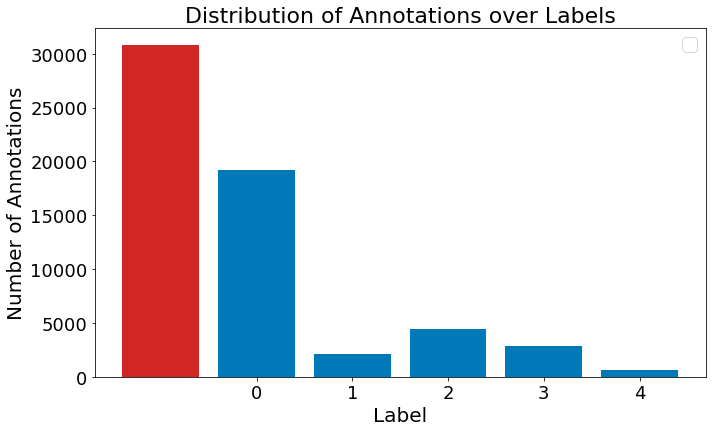

In [33]:
# count annotations per label
class_counts = df[ANNOTATOR_COLUMNS].stack().value_counts()

fig1 = plt.figure(figsize=(10, 6))

plt.bar(class_counts.index, class_counts.values, color=['#d22625'] + ['#0079b9'] * (len(class_counts) - 1))  # Grau für den ersten Balken, blau für die anderen

plt.xlabel('Label', fontsize=20)
plt.ylabel('Number of Annotations', fontsize=20)
plt.title('Distribution of Annotations over Labels', fontsize=22)
plt.legend(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.xticks([0, 1, 2, 3, 4], fontsize=18)
plt.show()

fig1.savefig('distr_over_annos_new2.png', dpi=100)

In [26]:
class_counts

-1    92020
 0    57380
 2    13147
 3     8452
 1     6230
 4     1901
dtype: int64

The most left bar depicts the number of labels missing, as not every annotator labels any data point.

In [49]:
print(f'Number of labels: \n{class_counts}')

Number of labels: 
-1    30810
 0    19237
 2     4394
 3     2821
 1     2084
 4      634
dtype: int64


In [50]:
class_counts_filtered = class_counts.drop(labels=-1)
total_counts = class_counts_filtered.sum()
class_percentages = (class_counts_filtered / total_counts) * 100
print(f'Percentage of labels: \n{class_percentages}')

Percentage of labels: 
0    65.947892
2    15.063421
3     9.670895
1     7.144326
4     2.173466
dtype: float64


In [51]:
df = df.drop('Unnamed: 0', axis=1)

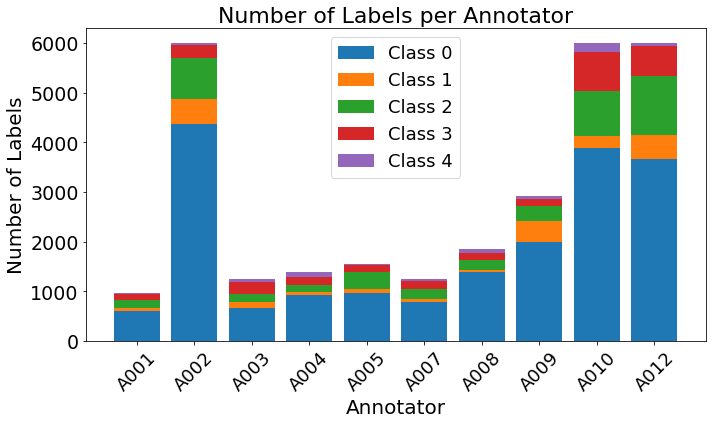

<Figure size 432x288 with 0 Axes>

In [52]:
# Count the number of classes per annotator
class_counts_per_annotator = df.iloc[:, 1:].apply(lambda x: x.value_counts()).T
class_counts_per_annotator = class_counts_per_annotator.reindex(ANNOTATOR_COLUMNS)

fig1 = plt.figure(figsize=(10, 6)) 

plt.bar(class_counts_per_annotator.index, class_counts_per_annotator[0], label='Class 0')
plt.bar(class_counts_per_annotator.index, class_counts_per_annotator[1], bottom=class_counts_per_annotator[0], label='Class 1')
plt.bar(class_counts_per_annotator.index, class_counts_per_annotator[2], bottom=class_counts_per_annotator[0] + class_counts_per_annotator[1], label='Class 2')
plt.bar(class_counts_per_annotator.index, class_counts_per_annotator[3], bottom=class_counts_per_annotator[0] + class_counts_per_annotator[1] + class_counts_per_annotator[2], label='Class 3')
plt.bar(class_counts_per_annotator.index, class_counts_per_annotator[4], bottom=class_counts_per_annotator[0] + class_counts_per_annotator[1] + class_counts_per_annotator[2] + class_counts_per_annotator[3], label='Class 4')

plt.xlabel('Annotator', fontsize=20)
plt.ylabel('Number of Labels', fontsize=20)
plt.title('Number of Labels per Annotator', fontsize=22)
plt.legend(fontsize=18)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=19)
plt.tight_layout()

plt.show()
plt.draw()

#fig1.savefig('distr_over_labels.png', dpi=100)

### Most frequent words

In [53]:
# print most frequent words excluding stopwords
german_stop_words = set(stopwords.words('german'))

def count_words(text):
    words = word_tokenize(text.lower())  
    cleaned_words = [word for word in words if word.isalpha() and word not in german_stop_words]
    return Counter(cleaned_words)

word_counts = df['text'].apply(count_words).sum()

most_common_words = word_counts.most_common(40)
print(most_common_words)

[('frauen', 1591), ('ja', 865), ('frau', 857), ('männer', 812), ('schon', 674), ('mehr', 649), ('immer', 479), ('mal', 438), ('mann', 423), ('gibt', 404), ('einfach', 359), ('halt', 328), ('geht', 324), ('ganz', 300), ('gut', 285), ('warum', 272), ('user', 271), ('wäre', 269), ('natürlich', 232), ('beim', 228), ('viele', 218), ('wohl', 208), ('eh', 205), ('gar', 205), ('männern', 201), ('müssen', 200), ('leben', 197), ('wirklich', 197), ('kinder', 193), ('genau', 189), ('wer', 188), ('menschen', 182), ('kommt', 181), ('tun', 177), ('eher', 172), ('bitte', 169), ('vielleicht', 167), ('macht', 163), ('eben', 161), ('eigentlich', 158)]


### Length
Investigate if there is a trend in data point length depending on label.

In [61]:
def print_middles(i,number_list):
    average = mean(number_list)
    median_value = median(number_list)
    print(f'Class {i} - Avg: {average}, Median: {median_value}')

In [56]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

In [57]:
lengths = {0: [], 1: [], 2: [], 3: [], 4: []}

for index, row in df.iterrows():
    for label in lengths.keys():
        lengths[label].extend([row['text_length']] * sum(row[ANNOTATOR_COLUMNS] == label))

l0, l1, l2, l3, l4 = lengths[0], lengths[1], lengths[2], lengths[3], lengths[4]

In [62]:
lengths = [l0, l1, l2, l3, l4]
for i, l in enumerate(lengths):
    print_middles(i,l)

Class 0 - Avg: 31.701356760409627, Median: 21
Class 1 - Avg: 37.63483685220729, Median: 27.0
Class 2 - Avg: 34.106053709604005, Median: 24.0
Class 3 - Avg: 32.436724565756826, Median: 23
Class 4 - Avg: 29.4211356466877, Median: 20.0


Assumption that length as feature may enhance classification of sexist comments (classes 1 to 4).

### Sentiment
Check if there is a trend in sentiment labels of comments according to labeled class.

In [63]:
model = SentimentModel()

In [64]:
df['sentiment'] = df['text'].apply(lambda x: model.predict_sentiment([x])[0])

In [73]:
def print_sentiment(i, word_list):
    word_counts = Counter(word_list)
    total_words = sum(word_counts.values())

    percentage_positive = (word_counts['positive'] / total_words) * 100
    percentage_neutral = (word_counts['neutral'] / total_words) * 100
    percentage_negative = (word_counts['negative'] / total_words) * 100

    print(f'Class {i}:')
    print(f'Positive: {percentage_positive:.2f}%, Neutral: {percentage_neutral:.2f}%, Negative: {percentage_negative:.2f}%')

In [66]:
s_lists = [[] for _ in range(5)]

for index, row in df.iterrows():
    for i in range(5):
        s_lists[i].extend([row['sentiment']] * sum(row[ANNOTATOR_COLUMNS] == i))

In [74]:
for i, s in enumerate(s_lists):
    print_sentiment(i, s)

Class 0:
Positive: 5.83%, Neutral: 49.48%, Negative: 44.70%
Class 1:
Positive: 5.85%, Neutral: 48.22%, Negative: 45.92%
Class 2:
Positive: 5.96%, Neutral: 49.11%, Negative: 44.92%
Class 3:
Positive: 5.32%, Neutral: 49.81%, Negative: 44.88%
Class 4:
Positive: 5.68%, Neutral: 48.90%, Negative: 45.43%


No trend can be seen.

## Word lists with specific sexist words

List of sexist terms generated via Prompt Engineering with ChatGPT 3.5.

In [76]:
sexist_terms = [
    "Schlampe",
    "Hure",
    "Zicke",
    "Weib",
    "Tussi",
    "Alte",
    "Tunte",
    "Miststück",
    "Flittchen",
    "Fräulein",
    "Luder",
    "Hysterisch",
    "Weiber",
    "Weiberheld",
    "Weiberwirtschaft",
    "Weibsvolk",
    "Weibsbild",
    "Männersache",
    "Mannweib",
    "Männerberuf",
    "Mannsweib",
    "Weiberkram",
    "Weiberfastnacht",
    "Weiberfeind",
    "Weibergerät",
    "Weiberhaushalt",
    "Weiberknecht",
    "Weiberkram",
    "Weiberkunde",
    "Weiberregiment",
    "Weibertreu",
    "Weiberzahn",
    "Weiberzeit",
    "Weibergeschrei",
    "Weibergestalt",
    "Weiberherrschaft",
    "Weibergeschlecht",
    "Weiberhof",
    "Weiblichkeit",
    "Weibchen",
    "Weibervolk",
    "Weibsvolk",
    "Weibsbild",
    "Weiberwirtschaft",
    "Weiberfeindlich",
    "Weiberarbeit",
    "Weiberklatsch",
    "Weiberkram",
    "Weibermacht",
    "Weiberwitz",
    "Weiberheld",
    "Weiberregiment",
    "Weiberwirtschaft",
]

In [82]:
tokenized_texts = [word_tokenize(text.lower()) for text in df['text']]
sexist_terms = [term.lower() for term in sexist_terms]

counts = Counter()
for tokens in tokenized_texts:
    for token in tokens:
        if token in sexist_terms:
            counts[token] += 1

total_words = sum(sum(1 for w in sentence) for sentence in tokenized_texts)
percent = {wort: (counts[wort] / total_words * 100) for wort in counts}

print(f'Amount of sexist terms: {counts} \n')
print(f'Amount in percent: {percent}')

Amount of sexist terms: Counter({'alte': 64, 'weiber': 27, 'tussi': 9, 'weibchen': 9, 'fräulein': 8, 'weiblichkeit': 8, 'weib': 6, 'hysterisch': 4, 'männersache': 2, 'männerberuf': 2, 'luder': 2, 'hure': 1, 'weibsvolk': 1, 'weibsbild': 1, 'schlampe': 1, 'mannweib': 1, 'zicke': 1}) 

Amount in percent: {'alte': 0.027649849221915962, 'weiber': 0.011664780140495797, 'hure': 0.0004320288940924369, 'weibsvolk': 0.0004320288940924369, 'fräulein': 0.0034562311527394952, 'weib': 0.0025921733645546214, 'weibsbild': 0.0004320288940924369, 'tussi': 0.0038882600468319317, 'männersache': 0.0008640577881848738, 'männerberuf': 0.0008640577881848738, 'schlampe': 0.0004320288940924369, 'weibchen': 0.0038882600468319317, 'mannweib': 0.0004320288940924369, 'weiblichkeit': 0.0034562311527394952, 'hysterisch': 0.0017281155763697476, 'luder': 0.0008640577881848738, 'zicke': 0.0004320288940924369}


## Agreement

Idea to aggregate different annotators into clusters to enhance data for training. Hence check for alignment.

### Krippendorff's Alpha
[updated]

Krippendorff’s alpha may better suited to calculate the interrater agreement, as it generalizes interrater reliability to an arbitrary number of raters and different types of data.

Krippendorff's Alpha Matrix of Agreement (pairwise):
          A001      A002      A003      A004      A005      A007      A008  \
A001  1.000000  0.003068  0.014414 -0.002222  0.004387  0.005012 -0.001331   
A002  0.003068  1.000000  0.042690  0.014792  0.027037  0.023044  0.002132   
A003  0.014414  0.042690  1.000000  0.010802  0.011237  0.000316  0.012676   
A004 -0.002222  0.014792  0.010802  1.000000 -0.000631 -0.002804  0.001773   
A005  0.004387  0.027037  0.011237 -0.000631  1.000000  0.001711  0.013679   
A007  0.005012  0.023044  0.000316 -0.002804  0.001711  1.000000  0.002443   
A008 -0.001331  0.002132  0.012676  0.001773  0.013679  0.002443  1.000000   
A009 -0.002542  0.001657  0.008337  0.001770  0.011299  0.012916  0.000873   
A010  0.000442  0.014006  0.010831 -0.000255  0.000219  0.000381  0.005593   
A012  0.002011  0.018774  0.008212 -0.000069 -0.000322 -0.000399  0.011416   

          A009      A010      A012  
A001 -0.002542  0.000442  0.002011  
A002  0.001657

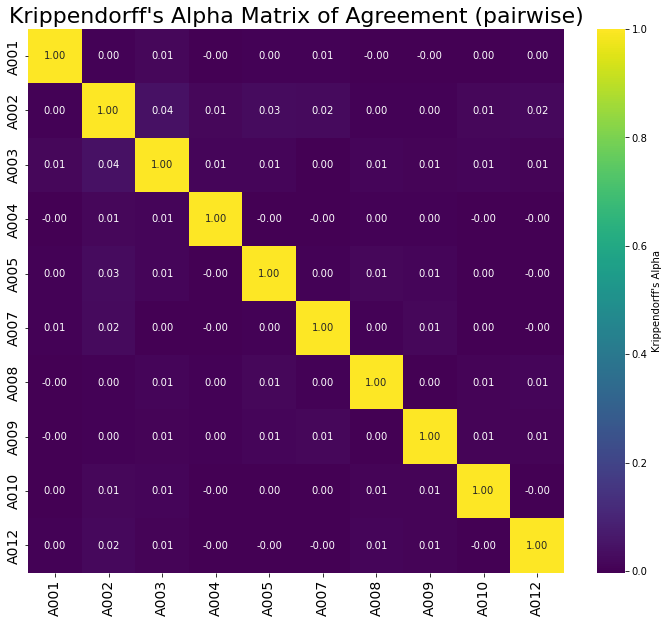

In [15]:
num_annotators = len(ANNOTATOR_COLUMNS)

# replace -1 (missing values) with NaN
df_annotations = df[ANNOTATOR_COLUMNS].replace(-1, np.nan)

df_annotations = df_annotations.apply(pd.to_numeric)
pairwise_alpha_matrix = np.zeros((num_annotators, num_annotators))

# calculate Krippendorff's Alpha - PAIRWISE
for i in range(num_annotators):
    for j in range(i + 1, num_annotators):
        annotator1 = ANNOTATOR_COLUMNS[i]
        annotator2 = ANNOTATOR_COLUMNS[j]
        valid_idx = df_annotations[[annotator1, annotator2]].dropna().index
        if len(valid_idx) > 0:
            pairwise_annotations = df_annotations.loc[valid_idx, [annotator1, annotator2]].values
            alpha = krippendorff.alpha(reliability_data=pairwise_annotations, level_of_measurement='ordinal')
            pairwise_alpha_matrix[i, j] = alpha
            pairwise_alpha_matrix[j, i] = alpha

np.fill_diagonal(pairwise_alpha_matrix, 1)

pairwise_alpha_df = pd.DataFrame(pairwise_alpha_matrix, index=ANNOTATOR_COLUMNS, columns=ANNOTATOR_COLUMNS)
print("Krippendorff's Alpha Matrix of Agreement (pairwise):")
print(pairwise_alpha_df)

plt.figure(figsize=(12, 10))
sns.heatmap(pairwise_alpha_df, annot=True, cmap='viridis', fmt='.2f', cbar_kws={'label': "Krippendorff's Alpha"})
plt.title("Krippendorff's Alpha Matrix of Agreement (pairwise)", fontsize=22)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.show()

Negative values can indicate
- that the level of agreement between annotators is worse than what would be expected by chance or
- issues with the data, e.g. extremely low levels of agreement or poor data quality.

It can also be caused by small sample sizes or a small number of annotations.

### Kappa's Alpha

[old]

Matrix of Agreement (Cohen's Kappa):
          A001      A002      A003      A004      A005      A007      A008  \
A001  1.000000  0.429713  0.422051  0.448889  0.529607  0.420590  0.447944   
A002  0.429713  1.000000  0.332061  0.325111  0.354783  0.352464  0.375490   
A003  0.422051  0.332061  1.000000  0.408076  0.426093  0.477486  0.421704   
A004  0.448889  0.325111  0.408076  1.000000  0.415506  0.522643  0.351474   
A005  0.529607  0.354783  0.426093  0.415506  1.000000  0.439707  0.283617   
A007  0.420590  0.352464  0.477486  0.522643  0.439707  1.000000  0.456751   
A008  0.447944  0.375490  0.421704  0.351474  0.283617  0.456751  1.000000   
A009  0.392809  0.378107  0.422170  0.364013  0.336985  0.368144  0.389163   
A010  0.440005  0.337634  0.461145  0.402902  0.387369  0.503045  0.391830   
A012  0.441144  0.339764  0.402383  0.348357  0.399289  0.423094  0.336032   

          A009      A010      A012  
A001  0.392809  0.440005  0.441144  
A002  0.378107  0.337634  0.33

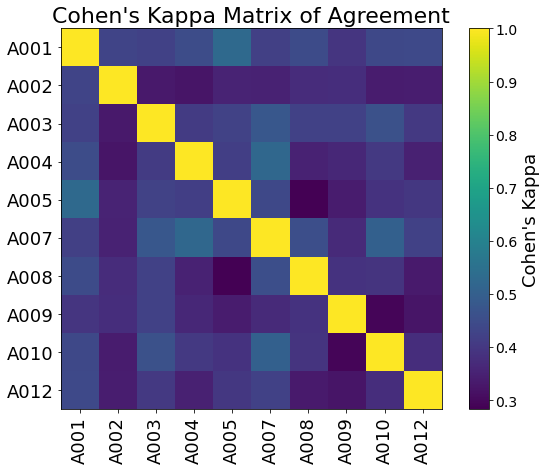

In [ ]:
kappa_matrix = np.zeros((len(ANNOTATOR_COLUMNS), len(ANNOTATOR_COLUMNS)))

for i, annotator1 in enumerate(ANNOTATOR_COLUMNS):
    for j, annotator2 in enumerate(ANNOTATOR_COLUMNS):
        if i < j:
            # only data points for which labels of both annotators exist
            valid_idx = (df[annotator1] != -1) & (df[annotator2] != -1)
            if valid_idx.sum() > 0:
                kappa = cohen_kappa_score(df.loc[valid_idx, annotator1], df.loc[valid_idx, annotator2])
                kappa_matrix[i, j] = kappa
                kappa_matrix[j, i] = kappa

np.fill_diagonal(kappa_matrix, 1)

kappa_df = pd.DataFrame(kappa_matrix, index=ANNOTATOR_COLUMNS, columns=ANNOTATOR_COLUMNS)
print("Matrix of Agreement (Cohen's Kappa):")
print(kappa_df)

plt.figure(figsize=(10, 7))
plt.imshow(kappa_df, cmap='viridis', interpolation='nearest')

cbar = plt.colorbar()
cbar.set_label("Cohen's Kappa", fontsize=18)
cbar.ax.tick_params(labelsize=14) 
plt.xticks(range(len(ANNOTATOR_COLUMNS)), ANNOTATOR_COLUMNS, rotation=90, fontsize=18)
plt.yticks(range(len(ANNOTATOR_COLUMNS)), ANNOTATOR_COLUMNS, fontsize=18)
plt.title("Cohen's Kappa Matrix of Agreement", fontsize=22)
plt.show()
#plt.savefig('cohen_kappa_matrix.png')

Regardless of the interrater agreement method used, agreement among raters is too little.